# Workflow for processing  Winton 08MAY18

## Instructions

These instructions are designed to be a step-by-step walk-through of the workflow to process field data and compare them to satellite data. or a new field dataset, only details in the first cell should need to be changed.

### Pre-requisites

In order for the workflow to run, there are a number of assumed requirements that should be met. Go through this check-list before running the workflow for the first time:
<OL>
    <LI>The Python library for this workflow can be found on VDI and should be copied into the working directory:<BR><BR>
    ```cp -r /home/547/aw3463/GuyData/calval/CalVal .```<BR><BR>
    <LI>The DEAPlotting library is also needed for RGB plots and should be copied to the working directory:<BR><BR>
    ```cp /home/547/aw3463/GuyData/calval/DEAPlotting.py .```<BR><BR>
    <LI>Transfer this Jupyter Notebook to VDI and start up the DEA module by typing:<BR><BR>
    ```> module load dea```<BR><BR>
    <LI>Copy the template to a new file and then start the notebook. eg:<BR><BR>
    ```> cp template.ipynb Pipeline-LG-26-03-18.ipynb```<BR>
    ```> jupyter notebook Pipeline-LG-26-03-18.ipynb```<BR><BR>
    <LI>Input and output directories should be defined in the first cell bleow, as 'indir' and 'output', respectively. For the input directory, it is assumed that there are multiple sub-directories, with format 'line1, line2, line3' etc. Note that lower case is required and no extra characters in the directory names. So 'Line1' or 'line_1' will not work. The output directory will be created by the workflow and is where PNG files will be stored. <BR><B>NOTE:</B> Each time the workflow is run, the output directory will be erased and re-written, so that the directory can be cleaned up.<BR><BR>
    <LI>Within each 'line' sub-directory, there should be radiance spectrum files in text format, with extension '.asd.rad.txt'.<BR><BR>
    <LI>There is a standard file that is used for determining the panel K-factor, currently located:<BR><BR>
        /g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/ga_panel1_jan_2018.txt<BR><BR>
    <LI>Satellite band response files are located in the directory:<BR><BR>
        /g/data1a/u46/users/aw3463/GuyByrne/misc_others/<BR><BR>
        including landsat8_vsir.flt and Sent2a.flt. Note that it is assumed that Sentinel 2a and 2b band responses are identical.<BR><BR>
    <LI>The 'field_data' list should be edited to contain the relevant information, which is used for plot titles and figure names, as well as identifying the correct satellite data. The final field for field_data describes whether the data were recorded in radiance or reflectance mode. Ideally, the data should be in radiances.<BR><BR>
    <LI>A time range (timerange) is specified, which bookends the date of the satellite overpass. Ideally, this would be set autmoatically, based on the time of the field data collection. However, in practice, the satellite data is ready weeks after the field data and earlier data validation may be required. So the time range should be set manually.<BR><BR>
    <LI>The lists 'bad_pans' and 'bad_grounds' can be left as empty for the first time running the workflow (eg. 'bad_pans = []'). These are used to specify any bad panel or ground readings identified later on.<BR><BR>
    <LI>Variables firstGoodLine, firstGroundSpec and firstGoodPanelSpec need to be specified. These are determined from knowledge of the field data and can be used to eliminate bad data at the start of the field collection. If all goes well, normally the first good line is number 1, the first good panel is number 0 and the first good ground spectrum is number 2. ie. there are two panel spectra at the start of line 1 (spec=0 and 1), followed by the first ground (spec=2).<BR><BR>
    <LI>The BRDF correction requires a separate directory and a new window on VDI. Do NOT use a window where you have already typed 'module load dea' because it needs slightly different modules. In this example, the directory '/g/data/u46/users/aw3463/GuyByrne/calval/brdf' is used. Once you have created your own directory and you have changed into that directory, type the following to copy of the required files:<BR><BR>
        ```> cp /g/data/u46/users/aw3463/GuyByrne/calval/brdf/* .```<BR><BR>
</OL>

### Calculating BRDF correction

One of the first things you need to do in this notebook is calculate the BRDF correction, but this requires that you read in the field data so that the latitude, longitude and time of the field data can be used to create the correction. Do the following steps:

<OL>
    <LI>Run the first five cells of this workflow.
    <LI>The fifth cell will print out scripts for determining the BRDF correction. You will see the script output below something like:<BR><BR>
        
        
        ###################################################################<BR>
        # Copy and paste the following into a terminal window on VDI for SATELLITE data  #<BR>
        ###################################################################<BR><BR>
        
        
   where 'SATELLITE' is either 'Landsat 8' or 'Sentinel 2'.<BR><BR>
    <LI>Copy and paste the output text directly into the brdf terminal window.<BR><BR>
    <LI>The result in the terminal window (takes about 30 seconds) will be a formatted version of the 'brdf_data' numpy array. This can be directly copied and pasted over the top of the existing brdf_data array at the bottom of the first cell in the notebook.<BR><BR>
        </OL>

### Running the notebook
Once the BRDF correction has been added to the notebook, it should be possible to run the notebook in its entirety. To do this, go to the top of the Jupyter Notebook and click on 'Kernel', then 'Restart & Run All', then click on the red button to confirm and run the workflow. It should take about 2-5 minutes to complete.

### Interpreting results of the first notebook run
Here, it is assumed that the notebook ran to completion, such that all the cells were processed. If the notebook stopped midway, then please see the <B>Troubleshooting</B> section below for some hints on what might have gone wrong.<BR><BR>
    
<B>Cell [4]</B> (Define 'alldata'...) lists a small section of the field data as a pandas dataframe. Only data for a wavelength of 350nm is shown. Check that the values in each column appear reasonable.<BR><BR>
    
<B>Figure 1</B> (Plot panel radiances...) will show overlay plots of panel radiances on both the left- and right-hand-sides, with the middle pane empty. All panel radiances should appear close together. If you notice a small number of panels that look significantly different, then these are probably bad panel radiances. You should try to identify the corresponding spectra and then add them to the 'bad_pans' list in Cell [2]. Once you have flagged the bad panel spectra, you should be able to re-run the notebook and this Figure will now show you the good and bad panels separated into the left and middle panes, respectively, with all panels together shown in the right pane.<BR><BR>
    
<B>Figure 2</B> (Diagnosis plots...) Will show various plots of any identified bad panel spectra. This is only used if you are curious about why some panel spectra may be misbehaving.<BR><BR>
    
<B>Figure 3</B> (Plot ground spectra...) shows two panes, which initially will be the same, showing an overlay of all the ground radiances (without panels). This plot can be used to identify any outlying ground radiances, which can be subsequently identified using 'bad_grounds' in Cell [2]. Once such bad radiances have been flagged, then the two panes will show a with/without comparison.<BR><BR>
    
<B>Figures 4 and 5</B> (Plot timelines...) will initially be the same. They show a line-by-line plot of the timelines of spectra taken, with the horizontal axis being seconds since the first spectrum was taken. Panel radiances are shown as blue crosses and ground radiances are shown as orange vertical lines. If there are any errant panel or graound radiances, based on the time they were taken, they can be identified here. Also, these plots can be used to assess when the panel readings for each line occur. If there are any bad panels or ground radiances, then they will be removed from the second figure.<BR><BR>
    
<B>Figure 6</B> (Create timeline...) Shows two panes with averaged radiances for panel spectra, as a function of time (in seconds, since the first spectrum). Initially they will show the same. The average panel readings should show a slowly changing curve that follows insolation. For example, field data taken in the morning will show a slowly rising curve, as the Sun rises. Deviatinos from this slowly changing curve may identify bad panel readings that should be flagged out in 'bad_pans' in Cell [2]. Once the notebook is re-run, any bad panels will be removed from the second pane.<BR><BR>
    
<B>Figure 7</B> (Plot all ground...) shows reflectance spectra for all good ground observations as black curves. Coloured curves show the average for all spectra in a Line. the right pane just shows a zoomed y-axis, compared to the left pane. Any unusually different spectra can be identified here and may be flagged in 'bad_grounds' in Cell [2].<BR><BR>
    
<B>Figure 8</B> (Plot band reflectances) shows the reflectance spectra averaged into the satellite bands.<BR><BR>
    
<B>Figure 9</B> (Histogram of all...) shows band-by-band histograms for all reflectances. The histograms typically conform to a Normal distribution, but unusually bright or dark spectra may be identified here.<BR><BR>
    
<B>Figure 10</B> (Plot satellite band...) show the median ground reflectance, together with the wavelength ranges for the satellite corresponding to the data. This is just to check that the satellite bands fall within well-behaved parts of the spectrum.<BR><BR>
    
<B>Figure 11</B> (Plot relative locations...) shows a relative longitude/latitude positions for both field and satellite data. A grid is also shown to represent the extent of the satellite pixels.<BR><BR>
    
<B>Figures 12, 13 and 14</B> show RGB images of the Satellite and field data, where the field data have been averaged into pixels that match the satellite data. Blank field pixels means that there is no field data corresponding to that pixel.<BR><BR>

<B>Figure 15</B> (Variance) shows the band-by-band satellite data, together with representative variance values in the title. Variance is defined as the ratio of the standard deviation, divided by the mean for each band. This gives an indication of how much variability there is in the field site. There should typically be less than 5% variance.<BR><BR>
    
<B>Figure 16</B> (Plot ratio arrays) shows band-by-band images of the ratio between satellite and field arrays. All images have been scales to ratios between 0.9 and 1.1, such that green colours indicate a close match between field and satellite pixels.<BR><BR>
    
<B>Figure 17</B> (Plot comparison spectra...) shows a band-by-band comparison of satellite and field data. Three spectra are shown. Black is the average spectrum for <I>all</I> satellite pixels, orange is the average for only those satellite pixels that overlap with at least one field spectrum. The blue spectrum shows the average for all field data. Any difference between the orange and black spectra is indicative of the variation in the ground spectrum, as measured by the satellite at slightly varying positions, so it gives a guide for how reliable the satellite data is.<BR><BR>
    
<B>Figure 18</B> (Comparison plot of...) shows a scatter plot, comparing the satellite and field data where there is at least one field spectrum overlapping with each satellite pixel. Different bands are shown with different symbols and colours.<BR><BR>
    
<B>Figure 19</B> shows the same as Figure 17, but for each band all the pixel data is averaged, so there is one data point per band. Error-bars are shown, which represent the standard deviation of the satellite and field data.<BR><BR>
    
### Troubleshooting
If the notebook does not complete, there are a few likely causes that can be checked.<BR>
    
It is possible that field data were recorded without GPS location information in the header. In such cases, the header will appear like:

```
GPS-Latitude is S0
GPS-Longitude is E0
```

The notebook will automatically identify such cases and try to deal with them, but it needs to know the coordinates for the box over which the field data was measured. These coordinates are fed into the variable "Corners" at the bottom of Cell [3], along with a True/False declaration for "RockWalk". If no coordinates are given and datacube manages to find satellite data, you are likely to see the Sydney Opera House in Cell [34] (large-area context RGB map). The coordinate fix necessarily makes assumptions about how the field data were collected. In particular, the direction the data collector was walking. It is assumed that the collection started at the South-East corner, walking in the direction of the South-West corner. "RockWalk", if set to True, will assume that the collector walked in a East -> West line, then West -> East, then East -> West etc. If "RockWalk" is set to False, then it is assumed the direction of walk is always East -> West.<BR>
    <B>Note</B>: Cell [29] will always say whether or not good GPS coordinates were found.<BR><BR>

#### Cell [4] (Define 'alldata'...) errors:
One of the most common is that the code will fail on Cell [4] (Define 'alldata'...), which is most likely because the input data files or directories are incorrectly formatted. Here are a list of errors and likely solutions:<BR>
<B>ValueError: No objects to concatenate</B>: The code cannot find any relevant files. Check 'indir' is correct, check the line directories are formatted as line1, line2 etc. Also check .asd.rad.txt files in the line directories.<BR><BR>
    
<B>ValueError: not enough values to unpack (expected 6, got 0)</B>: Most likely there is one (or more) .asd.rad.txt file with incorrectly formatted header information. For example, a file that is not a spectrum at all.<BR><BR>
    
<B>ValueError: invalid literal for int() with base 10</B>: This is casued by an incorrectly formatted spectral file name, which is found on line 39 of the header. The code requires this line to be in the format \*00.asd.rad or \*00.asd, where the two numbers '00' will be read as the spectrum number. This error complains that it is finding a string at this position, rather than a number.<BR><BR>
    
#### Datacube query errors:
The notebook uses Datacube to extract satellite data for comparison. However, it is only expect that exactly one satellite dataset will be found. So errors can occur when no, or more than one dataset is found.<BR><BR>

<B>Cell [27]: KeyError: 'the label [band11] is not in the [index]'</B>: This error occurs when you have previously generated a brdf_data array for Sentinel data but then process the workflow, assuming Landsat 8 data, with fewer bands. In this case, you need to re-calculate your BRDF array in Cell [4] for the correct satellite.<BR><BR>

<B>Cell [30]: AttributeError: 'Dataset' object has no attribute 'x'</B>: This error is casued by Datacube not finding any relevant satellite data for the timerange given in Cell [2]. Check the dates given in timerange. Also check that Datacube contains the data that you are looking for. It is possible that the data have yet to be indexed, if the observations were recent.<BR><BR>
    
<B>Cell [30]: ValueError: cannot rename '1' because it is not a variable or dimension in this dataset</B>: This error also happens because datacube has not found any relevant satellite data for the time range.<BR><BR>
    
<B>Cell [37] AttributeError: Unknown property levels</B>. You will also see wierd histograms in this cell, where you expect to see colour images:<BR>
This error is because Datacube found more than one observation for the selected timerange. This can happen if the timerange start and end dates are too far apart. It is also possible that this can happen if your field site is located in the overlapping region between two adjoining satellite observations. If it is the second case, you will need to enter a specific timerange (including hours/mins/seconds) that includes only the one observation you are interested in.<BR><BR>

In [1]:
import time
start_time = time.time()

import numpy as np

#
# Set up input and output directories
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/winton/8_may_2018/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/WIN-08MAY18/'

#
# field_data is in the format: 'Field Site Name', 'Date', 'Site number', 'Satellite Name'
# NOTE: Satellite name should be one of: 'Landsat8', 'Sentinel2a', or 'Sentinel2b'.
#
field_data = ['WIN', '08MAY18', '', 'Sentinel2b', 'Radiance']

#
# timerange gives the dates which include the relevant satellite overpass.
#
timerange = ('2018-05-02', '2018-05-09')

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
#bad_grounds = ['llg_l300010.asd.rad', 'llg_l300011.asd.rad', 'llg_l300038.asd.rad', 'llg_l300039.asd.rad', 'llg_l300040.asd.rad', 'llg_l300041.asd.rad']
bad_grounds = []
#bad_pans = ['lkg_l700000.asd.rad', 'lkg_l700001.asd.rad']
bad_pans = []

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 40
firstGoodGroundSpec = 50

#
# Calculated BRDF data
#
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.033272, 0.032080000000000004, 0.007152],
                          ['band11', 0.10519200000000001, 0.034756, 0.023252000000000002],
                          ['band12', 0.069, 0.018696, 0.016640000000000002],
                          ['band2', 0.033272, 0.032080000000000004, 0.007152],
                          ['band3', 0.064136, 0.039408, 0.015808000000000003],
                          ['band4', 0.06154, 0.034756, 0.017240000000000002],
                          ['band5', 0.06154, 0.034756, 0.017240000000000002],
                          ['band6', 0.06154, 0.034756, 0.017240000000000002],
                          ['band7', 0.12370400000000001, 0.05086, 0.028644000000000003],
                          ['band8', 0.12370400000000001, 0.05086, 0.028644000000000003],
                          ['band8a', 0.12370400000000001, 0.05086, 0.028644000000000003],
                         ])

#
# plot_scale defines the extent of the axes in the final two plots in the workflow.
# A scale from 0-1 means no reflectance to perfect reflectance. Typically, dark sites
# will range from 0-0.3, whereas bright sites will be between 0-1.
#
plot_scale = [0.0, 1.0, 0.0, 1.0]

In [2]:
import matplotlib.pyplot as plt
import matplotlib

#
# Astropy is used to determine the Solar angle
#
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

import datacube

from CalVal import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})

In [3]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################
#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
if field_data[4] == 'Radiance':
    suffix = 'asd.rad.txt'
else: 
    suffix = 'asd.txt'

panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
in_panel = 'ga_panel1_jan_2018.txt'

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Start Figure numbering at 1
#
fignum = 1

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
Corners = [-22.527814, 142.938542, -22.527678, 142.937665, -22.526910, 142.938677, -22.526825, 142.937692]
RockWalk = False
StartCorner = 'SE'

### Define 'alldata' as the dataframe that contains all the raw spectra.
Show the first wavelength of every spectrum, so that the data integrity can be checked.

In [4]:
alldata = LoadData.load_from_dir(indir, suffix, firstGoodLine, Corners)

alldata[alldata['Wavelength']==350]

,Wavelength,radiance,filename,date_saved,Latitude,Longitude,Line,Spec_number,Inst_number,SWIR1_gain,SWIR1_offset,SWIR2_gain,SWIR2_offset
0,350,0.100947,20180501_WintonCal00040.asd.rad,2018-05-07 23:57:35,-22.527814,142.938542,1,40,16516/1,44,2054,54,2140
0,350,0.100973,20180501_WintonCal00041.asd.rad,2018-05-07 23:57:38,-22.527814,142.938542,1,41,16516/1,44,2054,54,2140
0,350,0.100926,20180501_WintonCal00042.asd.rad,2018-05-07 23:57:41,-22.527814,142.938542,1,42,16516/1,44,2054,54,2140
0,350,0.100978,20180501_WintonCal00043.asd.rad,2018-05-07 23:57:43,-22.527814,142.938542,1,43,16516/1,44,2054,54,2140
0,350,0.101102,20180501_WintonCal00044.asd.rad,2018-05-07 23:57:46,-22.527814,142.938542,1,44,16516/1,44,2054,54,2140
0,350,0.101109,20180501_WintonCal00045.asd.rad,2018-05-07 23:57:49,-22.527814,142.938542,1,45,16516/1,44,2054,54,2140
0,350,0.101053,20180501_WintonCal00046.asd.rad,2018-05-07 23:57:51,-22.527814,142.938542,1,46,16516/1,44,2054,54,2140
0,350,0.101022,20180501_WintonCal00047.asd.rad,2018-05-07 23:57:54,-22.527814,142.938542,1,47,16516/1,44,2054,54,2140
0,350,0.100975,20180501_WintonCal00048.asd.rad,2018-05-07 23:57:56,-22.527814,142.938542,1,48,16516/1,44,2054,54,2140
0,350,0.100985,20180501_WintonCal00049.asd.rad,2018-05-07 23:57:59,-22.527814,142.938542,1,49,16516/1,44,2054,54,2140


### Print out time stamp and coordinate extent for BRDF correction

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the current directory.


In [5]:
PrintBRDF.print_brdf(alldata, field_data)

##################################################################################
# Copy and paste the following into a terminal window on VDI for Sentinel 2 data #
##################################################################################

source module.sh
sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-05-07 23:57:35'))/" retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(142.938542, -22.527814, 142.938542, -22.527814)]})/" retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format_Sent.awk temp.txt



### Specify which spectra are panels/ground/good/bad

 Determine panel file names by assuming that all panels have a data value of at least 0.06
 in the first wavelength (350nm). Call this dataframe 'panel_names'.

 good_panels = all panel data with bad panels removed<BR>
 bad_panels  = all bad panel data<BR>
 all_panels = both good and bad panel data<BR>
 good_grounds = good ground readings<BR>
 all_grounds = all ground data.<P>
 Any bad ground data (bad_grounds) is defined in the 2nd cell.


In [6]:
panel_names, all_panels, good_panels, bad_panels, good_grounds, all_grounds = ExtractPanelsGrounds.extract_panels_grounds(alldata, bad_pans, bad_grounds)

### Create dataframes for all/good/bad panel spectra.

For the bad panel spectra dataframe, first check to see if bad panels have been defined.<BR>
If not, then don't create anything.

In [7]:
all_panel_spec = MakeSpecDF.make_spec_df(all_panels)
good_panel_spec = MakeSpecDF.make_spec_df(good_panels)
try:
    bad_panel_spec = MakeSpecDF.make_spec_df(bad_panels)
except UnboundLocalError:
    pass

# Figure 

### Plot panel radiances for all/good/bad panels

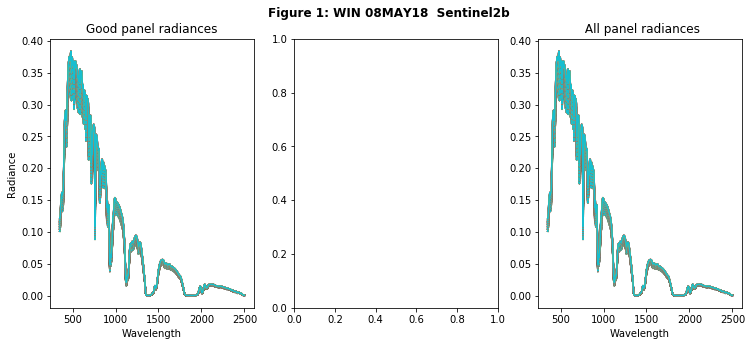

In [8]:
try:
    FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)
except NameError:
    bad_panel_spec = [0,0]
    FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)

fignum += 1

# Figure 

### Diagnosis plots of bad panel spectra

In [9]:
good_panel_mean = good_panel_spec.mean(axis=1)

try:
    FIG_BadPanelAnalysis.FIG_bad_panel_analysis(good_panel_mean, good_panel_spec, bad_panel_spec, output, field_data, fignum)
except AttributeError:
    pass
fignum +=1

### Create spectral dataframes for all ground spectra and good ground spectra

In [10]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds)
good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds)

# Figure 

### Plot ground spectra (all and good), normalised to the median good spectrum

These plots are used to identify any ground spectra that are bogus.

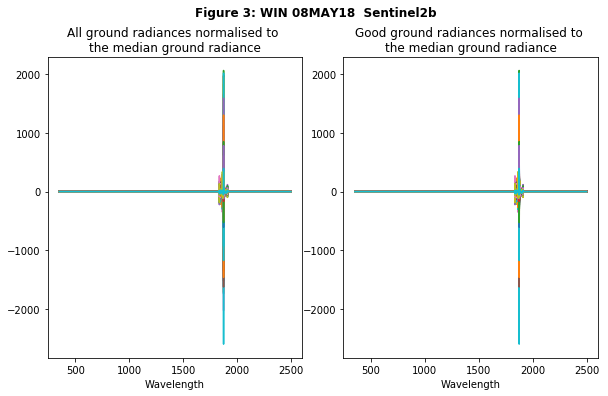

In [11]:
FIG_GroundSpectra.FIG_ground_spectra(good_grounds_spec, all_grounds_spec, output, field_data, fignum)
fignum +=1

### Create time-relative dataframes

gpt = good panels<BR>
gpta = all panels<BR>
adt = good grounds<BR>
adta = all grounds

In [12]:
gpt, gpta, adt, adta = CreateTimeRelativeDF.create_time_relative_dfs(good_panels, all_panels, good_grounds, all_grounds)

# Figure 

### Plot timelines for ALL panel and ground data, with one line in one panel

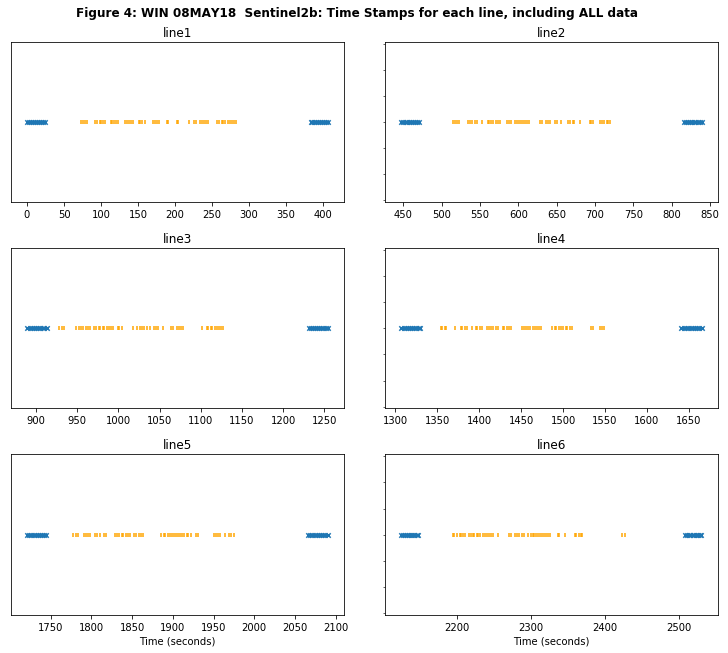

In [13]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, output, field_data, fignum)
fignum += 1

# Figure 

### Plot timelines for GOOD panel and ground data, with one line in one panel

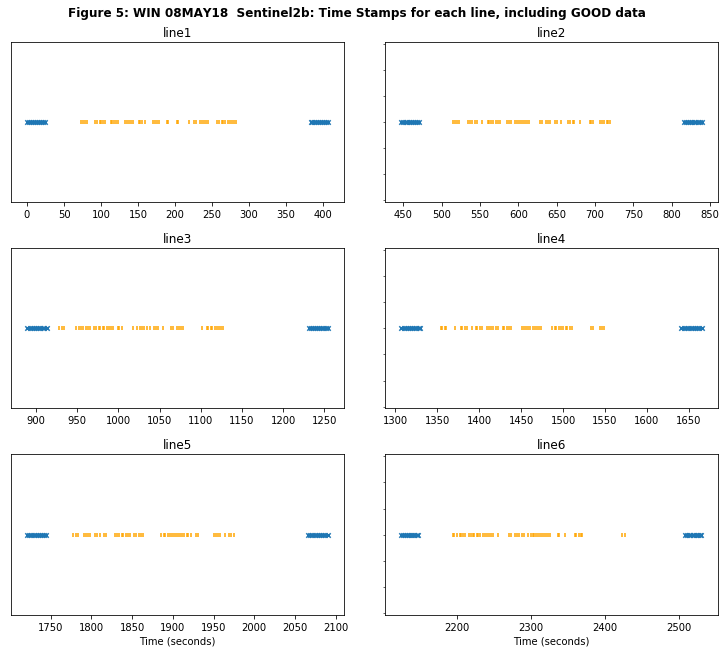

In [14]:
from CalVal.FIG_AllTimelines import panel_plot_layout, multi_timeline_plot

FIG_GoodTimelines.FIG_good_timelines(gpta, gpt, adt, panel_plot_layout, multi_timeline_plot, output, field_data, fignum)
fignum += 1

# Figure 

### Create timeline plot of averaged, normalised all/good panels

These plots are used to identify any panels that show unusually bright or dark readings,<BR>
    which can be weeded out as bad panels.
    
The general shape of the curve should follow "insolation" - the changing of incident light
due to the Sun rising/falling in the sky.

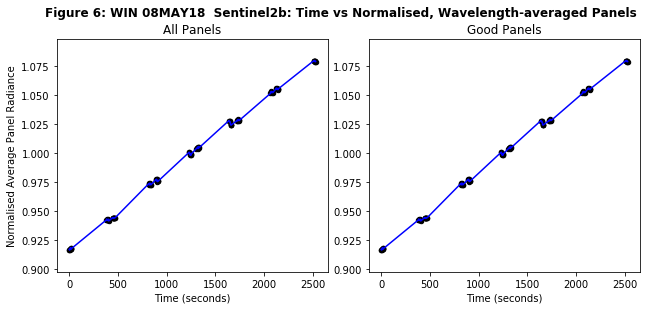

In [15]:
gpt, gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(good_panel_mean, good_panel_spec, all_panel_spec, gpt, gpta)
    
FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpt, gpta, output, field_data, fignum)
fignum += 1

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [16]:
k_f = KFactor.k_factor(panel_dir, in_panel)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [17]:
SpecRename.spec_rename(good_panel_spec, good_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec)

### Create dataframe with Reflectances

In [18]:
all_refls = CreateReflectances.create_reflectances(good_panels, good_panel_spec, good_grounds_spec, k_f)

### Test for reflectances
Test field_data to see if the data were saved as reflectances. If so, bypass all the panelling workflow.

In [19]:
if field_data[4] == 'Reflectance':
    all_refls = good_grounds_spec

# Figure 

### Plot all ground reflectances in black, plus the Line-averaged reflectances in colour

The Line-averaged reflectances are shown in order to identify any outlying lines that<BR>

might have been caused by bad panel spectra (for example).

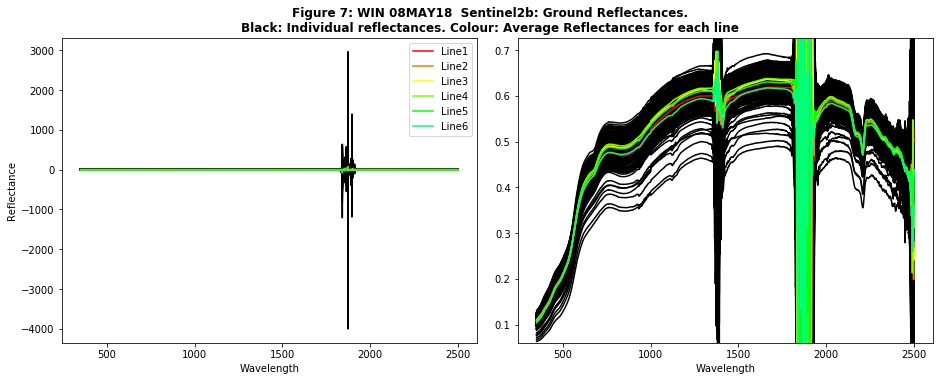

In [20]:
FIG_Reflectances.FIG_reflectances(good_panels, all_refls, colpac, output, field_data, fignum)
fignum += 1

### Apply weighted band responses to all reflectances

In [21]:
result_df, band = ApplyWeights.apply_weights(f_name, all_refls)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [22]:
ground_bands = ReformatDF.reformat_df(good_grounds, result_df)

# Figure 

### Plot band reflectances

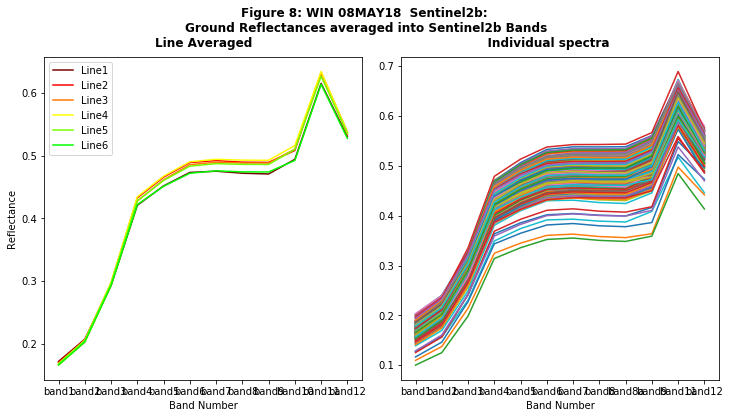

In [23]:
FIG_BandReflectances.FIG_band_reflectances(ground_bands, result_df, band, colpac, output, field_data, fignum)
fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

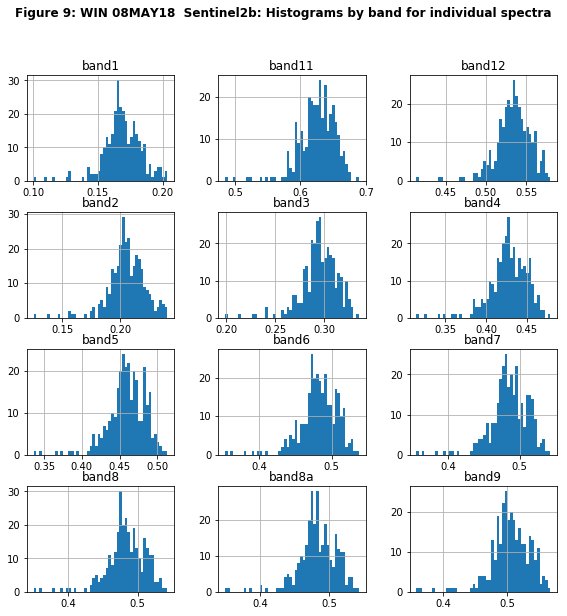

In [24]:
FIG_SpecHistogram.FIG_spec_histogram(ground_bands, output, field_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [25]:
maxfile = ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].max())]
maxbands = ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].max())]
minfile = ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].min())]
minbands = ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].min())]

print("Maximum value found in:", maxfile.iloc[0], '\n', maxbands.iloc[0], '\nMinimum value found in:', minfile.iloc[0], '\n', minbands.iloc[0])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].max())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].max())])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].min())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].min())])


Maximum value found in: 20180501_WintonCal00096.asd.rad 
 band1     0.203591
band2     0.239721
band3     0.324213
band4     0.453975
band5     0.485975
band6     0.507890
band7     0.507187
band8     0.500868
band8a    0.498205
band9     0.523538
band11    0.659088
band12    0.579969
Name: 46, dtype: float64 
Minimum value found in: 20180501_WintonCal00402.asd.rad 
 band1     0.100430
band2     0.125411
band3     0.198815
band4     0.314172
band5     0.335844
band6     0.352391
band7     0.355184
band8     0.350528
band8a    0.348462
band9     0.359049
band11    0.484563
band12    0.413535
Name: 252, dtype: float64


### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [26]:
def solar_angle(row):

    loc = coord.EarthLocation(lon=row['Longitude'] * u.deg,
                              lat=row['Latitude'] * u.deg)
    #timy0 = timei.to_pydatetime()
    timy = Time(row['date_saved'], format='datetime')
    
    altaz = coord.AltAz(location=loc, obstime=timy)
    sun = coord.get_sun(timy)

    return sun.transform_to(altaz).zen.degree

ground_bands['Solar_angle'] = ground_bands.apply(solar_angle, axis=1)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [27]:
ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ground_bands)

### Choose bands for Landsat 8 and Sentinel satellite data

In [28]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7,8]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

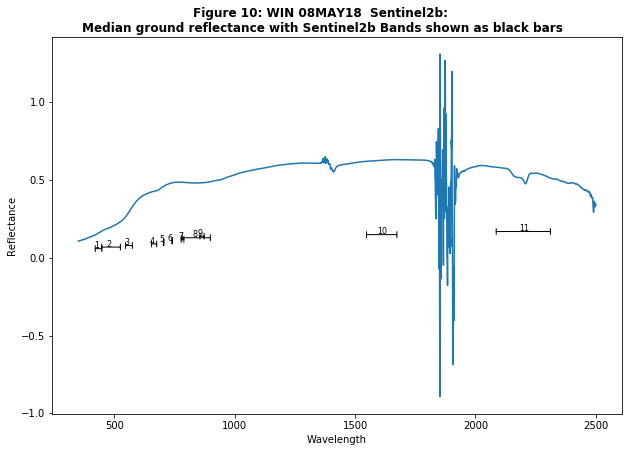

In [29]:
FIG_BandExtents.FIG_band_extents(all_refls, band_min, band_max, output, field_data, fignum)
fignum += 1

### Fudge GPS locations if none exist

In [30]:
ground_brdf = FudgeGPS.fudge_gps(ground_brdf, Corners, RockWalk, StartCorner)

No good GPS Coordinates found, fudging...


### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.

In [31]:
dc, query, query2 = Query.make_query(timerange, ground_brdf, field_data)

sat_array, sat_bigarray = CreateSatArrays.create_sat_arrays(dc, query, query2, field_data)

# Figure 

### Plot relative locations of field and satellite data

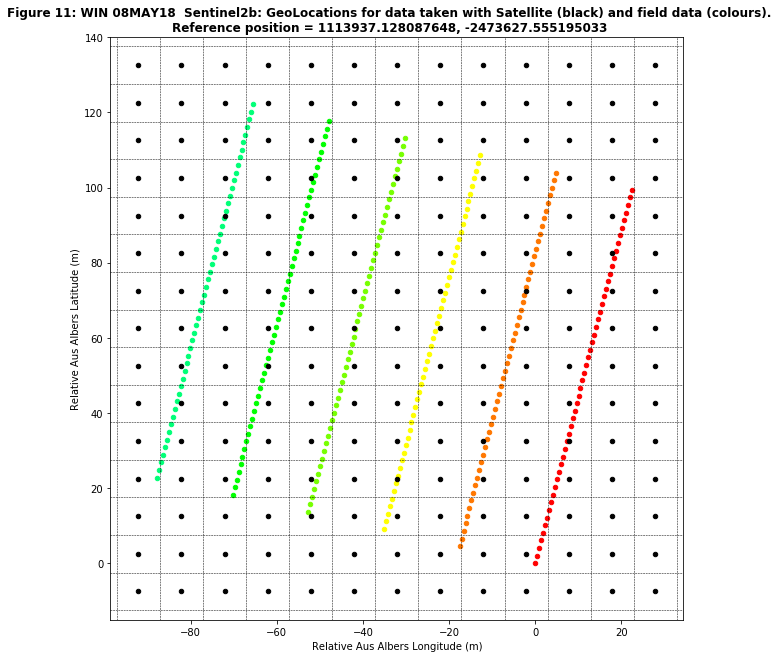

In [32]:
xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ground_brdf, sat_array, colpac, output, field_data, fignum)
fignum +=1

### Create Australian albers columns for ground_brdf (not used)

In [33]:
#for i in range(len(ground_brdf)):
#    ground_brdf['Xalbers'], ground_brdf['Yalbers'] = pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][i], ground_brdf['Latitude'][i])
#    
#print(ground_brdf['Xalbers'][4], ground_brdf['Yalbers'][4])
#
#pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][4], ground_brdf['Latitude'][4])

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [34]:
field_array = CreateFieldFromSat.create_field_from_sat(sat_array, ground_brdf, xloc, field_data)

# Figure 

### Plot large-area context RGB array for Satellite data

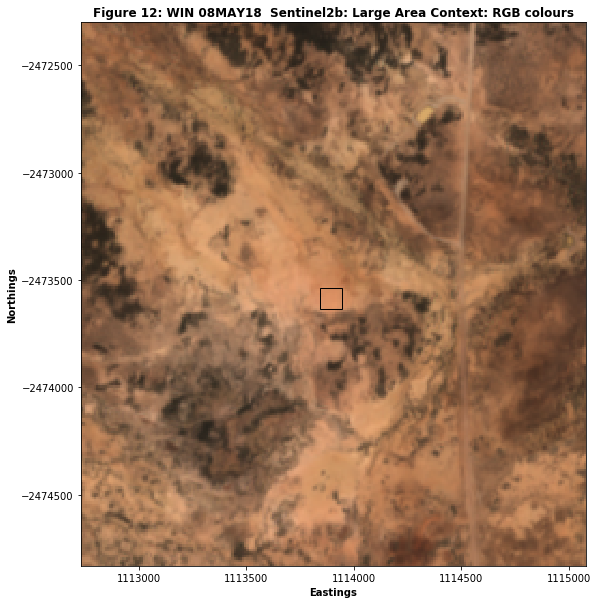

In [36]:
FIG_SatBigRGB.FIG_sat_bigRGB(sat_array, sat_bigarray, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Satellite data

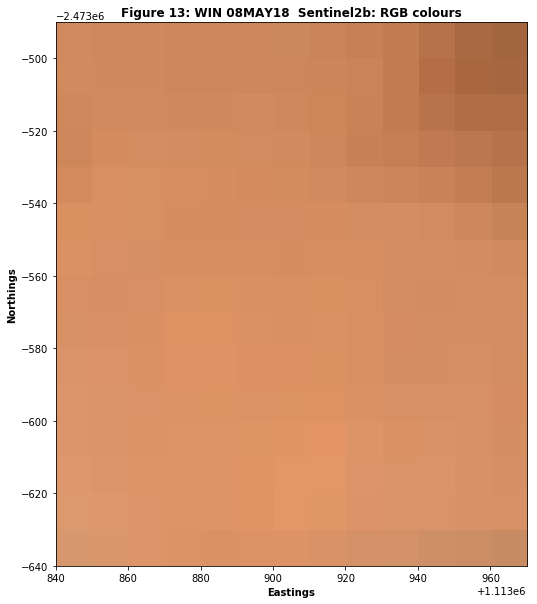

In [37]:
FIG_SatRGB.FIG_sat_RGB(sat_array, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


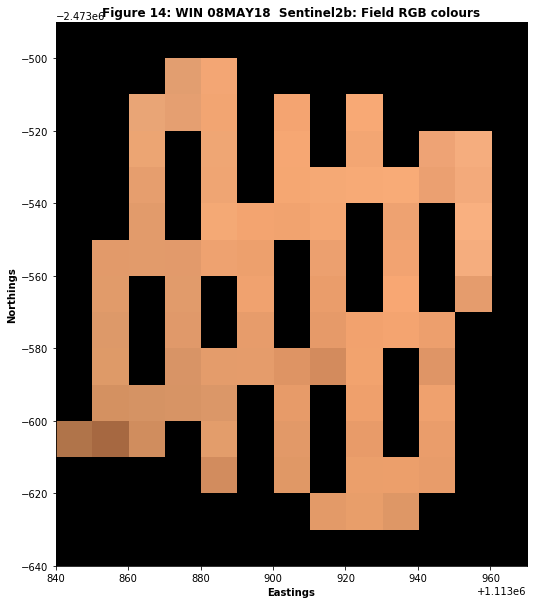

In [38]:
FIG_FieldRGB.FIG_field_RGB(field_array, output, field_data, fignum)
fignum += 1

### Test query for Sentinel 2 data (not used)

In [39]:
# dc2 = datacube.Datacube(config='/home/547/aw3463/sentinel2.config')
#
#query = {
#        'lat': (-35.25, -35.35),
#        'lon': (149.05, 149.17),
#        'output_crs': 'EPSG:3577',
#        'resolution': (-10, 10),
#        'time':('2017-10-01', '2018-05-15')
#        }
#
#canberra = dc2.load(product='s2b_ard_granule', **query)
#
#canberra

## Figure
### Variance of satellite data

Band-by-band plots of the ratio of satellite data, divided by the mean, for each band are shown.
The title also lists the min, max and mean variance. Variance is defined as the ratio of the standard
deviation divided by the mean, for each band. The mean variance should typically be less than 5%.

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/_collections_abc.py:761: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for key in self._mapping:


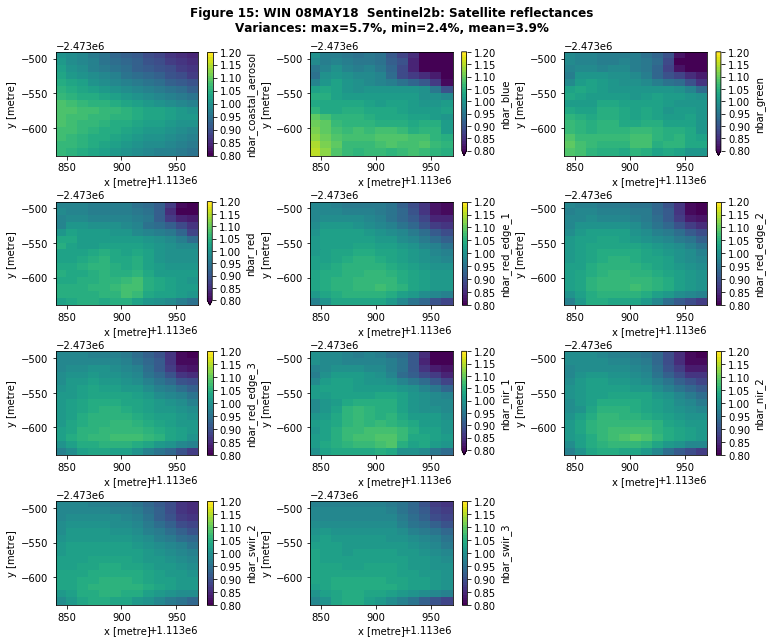

In [40]:
FIG_SatBands.FIG_sat_bands(sat_array, field_array, output, field_data, fignum)
fignum += 1

# Figure

### Plot ratio arrays for each band

Each panel shows the ratio of satellite/field data.

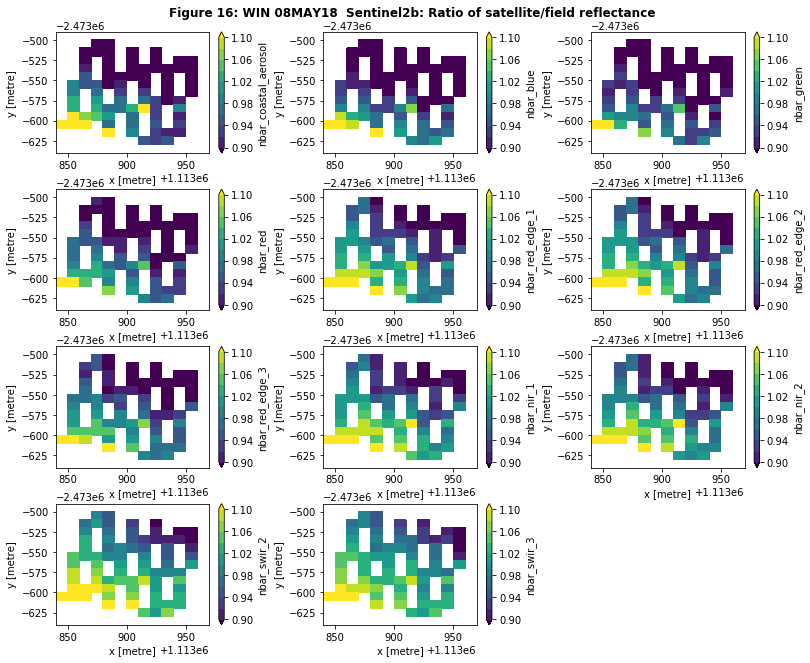

In [41]:
FIG_RatioArrays.FIG_ratio_arrays(sat_array, field_array, output, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [42]:
fstat_df = CreateStats.create_stats(sat_array, ground_brdf, field_data)

## Create a statistics dataframe, comparing satellite and field data,
for only those satellite pixels which overlap with at least one field data position.

In [43]:
finner_df = CreateSubStats.create_SUB_stats(sat_array, field_array, ground_brdf, fstat_df, field_data)

# Figure

### Plot comparison spectra of satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the satellite and field data, based on the standard deviation of the pixels
within the field. The black line shows the satellite data, which has been averaged over all pixels that satisfy the Datacube query ie. all pixels shown in Figure 11. The orange line shows satellite data which has been averaged over only those pixels that overlap with at least one field measurement.

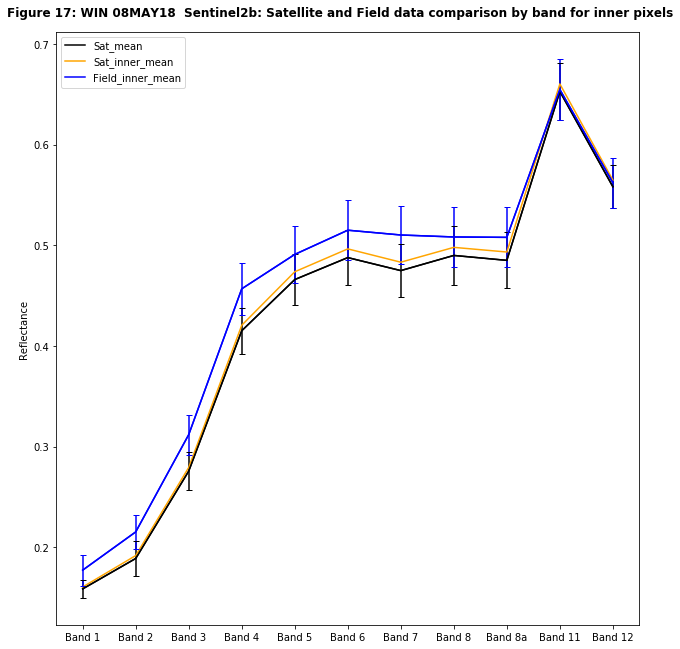

In [44]:
FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(sat_array, fstat_df, finner_df, output, field_data, fignum)
fignum += 1

# Figure

### Comparison plot of Field and satellite data

Plot shows a pixel-by-pixel comparison of all pixels where field data exists.<BR> 
Different band data are shown in different colours and different symbols.

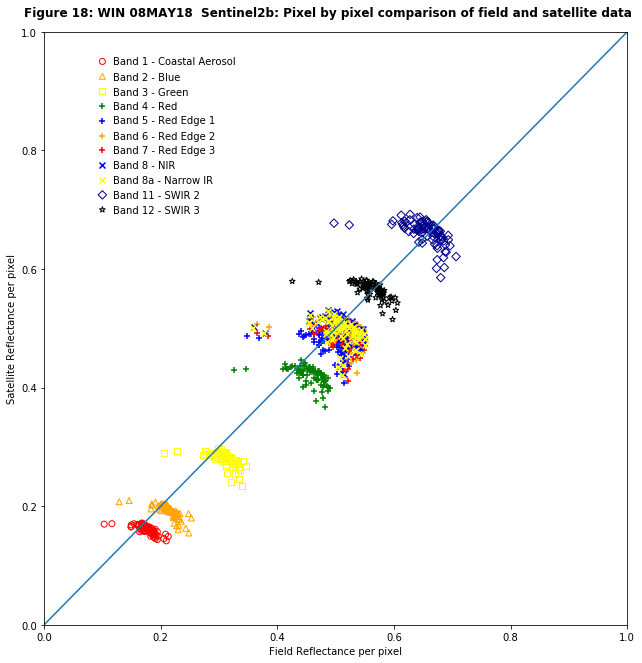

In [45]:
FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(sat_array, field_array, plot_scale, output, field_data, fignum)
fignum += 1

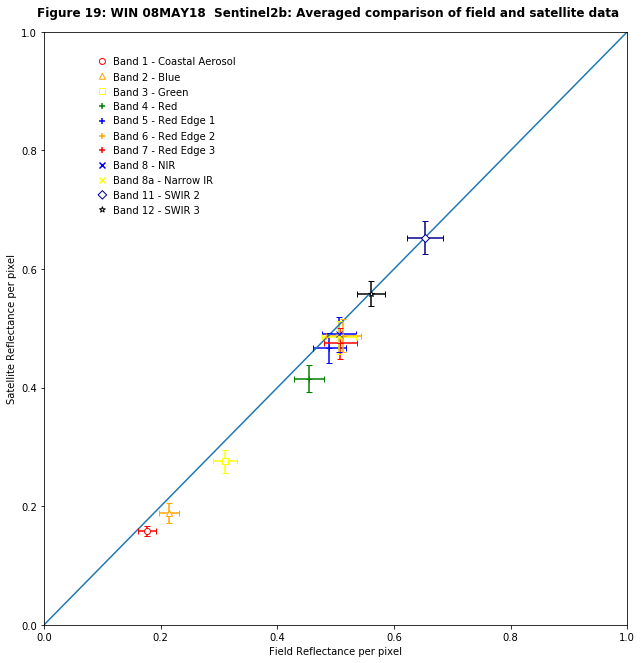

In [46]:
FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(sat_array, field_array, plot_scale, fstat_df, output, field_data, fignum)
fignum += 1

In [47]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

This Notebook took  0:04:14 (h:m:s) to run
